In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train=pd.read_csv('/content/drive/MyDrive/Diamond Price Prediction/train.csv')
train.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
1,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
2,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
3,6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
4,7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47


##data preprocessing

In [ ]:
# train = train.drop(["Unnamed: 0"], axis=1)
train.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,43040.000000,43040.000000,43040.000000,43040.000000,43040.000000,43040.000000,43040.000000,43040.000000
mean,26758.804554,0.796964,61.746080,57.439542,3942.706343,5.724376,5.728122,3.534367
std,15484.904515,0.481455,1.435246,2.240196,4023.534556,1.132496,1.159641,0.714543
min,2.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13326.750000,0.380000,61.000000,56.000000,940.000000,4.660000,4.670000,2.870000
50%,26824.500000,0.710000,61.800000,57.000000,2388.000000,5.710000,5.720000,3.530000
75%,40290.250000,1.030000,62.500000,59.000000,5309.250000,6.500000,6.500000,4.020000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [ ]:
#Dropping dimentionless diamonds
train = train.drop(train[train["x"]==0].index)
train = train.drop(train[train["y"]==0].index)
train = train.drop(train[train["z"]==0].index)
train.shape

(43023, 11)

In [ ]:
# def detect_outliers(df):
#     Q1 = df.quantile(0.25)
#     Q3 = df.quantile(0.75)
#     IQR = Q3 - Q1
    
#     cols=['x','y','z']
    
#     for col in cols:
#         mask = (
#             (df[col] < (Q1[col] - 1.5 * IQR[col])) |
#             (df[col] > (Q3[col] + 1.5 * IQR[col]))
#         )
        
#         df.loc[mask,col] = df[col].median()
#     return df

# def detect_outliers(train)

<b>cut</b>: determining the quality of the cut.(Fair, Good, Very Good, Premium, Ideal)<br>
<b>color</b>: diamond color, from J (worst) to D (best)<br>
<b>clarity </b>: a measurement of how clear the diamond is.(I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))<br>

In [ ]:
def label_encoder(df):
    df['color'].replace({'J':0, 'I':1, 'H':2, 'G':3, 'F':4, 'E':5, 'D':6}, inplace =True)
    df['cut'].replace({'Fair':0, 'Good':1, 'Very Good':2, 'Premium':3, 'Ideal':4}, inplace =True)
    df['clarity'].replace({'I1':0, 'SI2':1, 'SI1':2, 'VS2':3, 'VS1':4, 'VVS2':5, 'VVS1':6, 'IF':7}, inplace =True)
    return df

train=label_encoder(train)
train.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,2,0.21,3,5,2,59.8,61.0,326,3.89,3.84,2.31
1,4,0.29,3,1,3,62.4,58.0,334,4.20,4.23,2.63
2,5,0.31,1,0,1,63.3,58.0,335,4.34,4.35,2.75
3,6,0.24,2,0,5,62.8,57.0,336,3.94,3.96,2.48
4,7,0.24,2,1,6,62.3,57.0,336,3.95,3.98,2.47


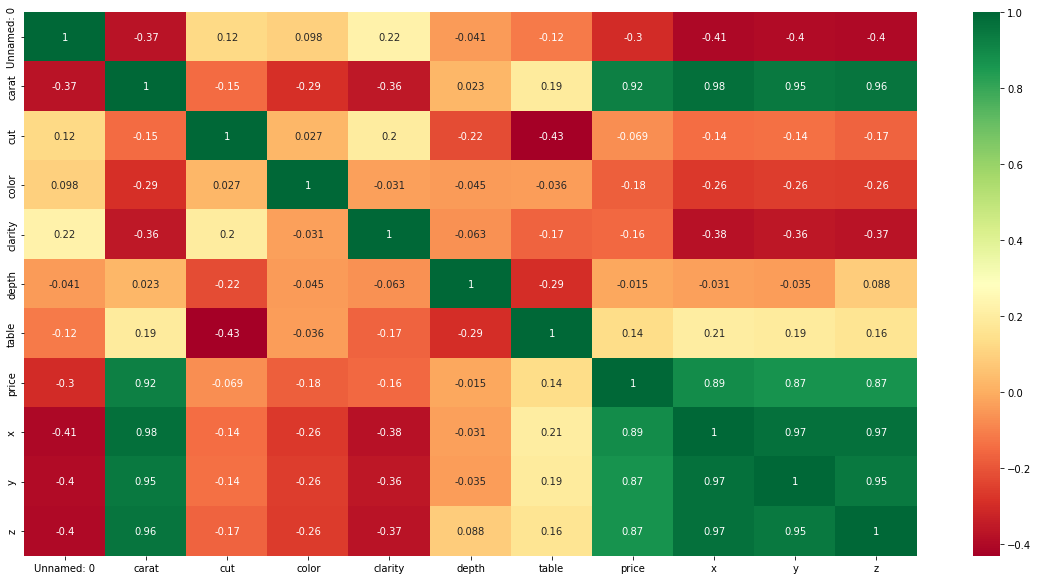

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

cor = train.corr()
sns.heatmap(cor, annot=True, cmap="RdYlGn")
plt.show()

In [ ]:
# Assigning the featurs as X and trarget as y
data=train.copy()
X= data.drop(columns=["price","Unnamed: 0"],axis =1)
y= data["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

##RandomForestRegressor

In [ ]:
pipeline_rf=Pipeline([("scalar",StandardScaler()),
                     ("rf_classifier",RandomForestRegressor())])
pipeline_rf.fit(X_train, y_train)
pred = pipeline_rf.predict(X_test)
print("RMSE:",np.sqrt(mean_squared_error(y_test, pred)))

RMSE: 529.3494495353572


In [ ]:
# Fine-Tune the model

param_distribs = {
        'n_estimators': np.random.randint(1, 200, 10),
        'max_features': np.random.randint(1, 8, 10),
    }

forest_reg = RandomForestRegressor()
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_features': array([3, 4, 3, 1, 4, 4, 7, 7, 1, 1]),
                                        'n_estimators': array([ 75,   6, 147, 175,  40, 160,   1, 198, 190,  59])},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
rnd_search.best_estimator_

RandomForestRegressor(max_features=7, n_estimators=75)

In [ ]:
forest_reg = RandomForestRegressor(max_features=7,n_estimators=75,random_state=38) 
forest_reg.fit(X_train,y_train)
pred = forest_reg.predict(X_test)
print("RMSE:",np.sqrt(mean_squared_error(y_test, pred)))
  

RMSE: 521.8886397291369


##XGBRegressor

In [ ]:
reg = XGBRegressor()
                   
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
print("RMSE:",np.sqrt(mean_squared_error(y_test, pred)))

[09:32:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 594.6823422335692


In [ ]:
# Fine-Tune the model
params = {
    'n_estimators':[500],
    'min_child_weight':[4,5], 
    'gamma':[i/10.0 for i in range(3,6)],              ## [0.3,0.4,0.5]
    'subsample':[i/10.0 for i in range(6,11)],         ## [0.6 ,0.7 ,0.8 ,0.9, 1.0]
    'colsample_bytree':[i/10.0 for i in range(6,11)],  ## [0.6 ,0.7 ,0.8 ,0.9, 1.0]
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)] ,             ## [0.3,0.4,0.5]
    "random_state":[i for i in range(1,51)]
} 

reg = XGBRegressor(nthread=-1)
random_search = RandomizedSearchCV(reg, param_distributions=params,
                                   n_iter=50 ,cv=5,scoring='neg_mean_squared_error')

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=XGBRegressor(nthread=-1), n_iter=50,
                   param_distributions={'booster': ['gbtree', 'gblinear'],
                                        'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'eta': [0.3, 0.4, 0.5],
                                        'eval_metric': ['rmse'],
                                        'gamma': [0.3, 0.4, 0.5],
                                        'max_depth': [2, 3, 4, 6, 7],
                                        'min_child_weight': [4, 5],
                                        'n_estimators': [500],
                                        'objective': ['reg:squarederror',
                                                      'reg:tweedie'],
                                        'random_state': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
    

In [ ]:
random_search.best_params_

In [ ]:
regX = XGBRegressor(   
                      subsample=1.0,
                      objective='reg:tweedie',
                      n_estimators= 500,
                      min_child_weight=4,
                      max_depth=4,
                      gamma=0.5,
                      eval_metric='rmse',
                      eta=0.5,
                      colsample_bytree= 0.6,
                      booster= 'gbtree',
                      random_state=48
                   )

regX.fit(X_train,y_train)
pred = regX.predict(X_test)
print("RMSE:",np.sqrt(mean_squared_error(y_test, pred)))

RMSE: 500.3764074227785


##submit:

In [ ]:
sample=pd.read_csv("/content/drive/MyDrive/Diamond Price Prediction/sample_submission.csv")
test=pd.read_csv('/content/drive/MyDrive/Diamond Price Prediction/test.csv')

test=label_encoder(test)
test.drop(columns=['Unnamed: 0'],inplace=True)

prediction = regX.predict(test)
sample['price'] = prediction
sample.to_csv("sub10.csv", index=False)